In [1]:
from IPython.display import clear_output
!rm -rf ./*
!pip install keras==2.15 
!pip install albumentations
!pip install keras-tuner
!git clone https://github.com/yunama47/Klasifikasi-Mammografi modul
clear_output()
print("-- dependency installs completed --")

-- dependency installs completed --


# Imports and some things

In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import cv2
import keras
import keras_tuner
import random
import numpy as np
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt

def seed_everything(seed=911):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(911)

class D:
    '''class that contain all the parameters'''
    #param for dataset
    image_size = (512,288)
    batch_size = 4
    shuffle_buffer = 3000
    views = ['Examined','Aux']
    
    #param for ConvNeXt multi-view model
    model_var = 'convnext_small'
    drop_path_rate = 0.2123456789
    dropout_rate   = 0.5123456789
    pooling ='w_avg'
    fusion_stage = 3
    fusion_index = 0
    fc_layers_depth = 1
    fc_layers_dims = 512
    
    #param for training
    epochs = 30
    loss_fn = 'categorical_crossentropy'
    optimizer = lambda: keras.optimizers.Adam(1e-5, use_ema=True)
    metrics = lambda : [
        keras.metrics.CategoricalAccuracy(name='accuracy'),
        keras.metrics.F1Score(average='macro',name='macro_F1')
    ]
try :
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    D.TPU = True
    D.batch_size *= 8
except ValueError:
    D.TPU = False
    strategy = tf.distribute.MirroredStrategy()
from IPython.display import clear_output
clear_output()
print("-- versions --")
print("tf :",tf.__version__)
print("keras :",keras.__version__)
print("keras_tuner :",keras_tuner.__version__)
print("albumentations :",A.__version__)
print("Number of accelerators: ", strategy.num_replicas_in_sync)

-- versions --
tf : 2.15.0
keras : 2.15.0
keras_tuner : 1.4.7
albumentations : 1.4.10
Number of accelerators:  8


# loading dataset

In [3]:
from random import choice

TOUT = "float32"

@tf.numpy_function(Tout=TOUT)
def cutout_mask(shape, n_holes, min_max_height, min_max_width):
    h, w, c = shape
    mask = np.ones(shape, dtype=np.float32)
    for _ in range(n_holes):
        y = np.random.randint(0, h)
        x = np.random.randint(0, w)
        hmax, hmin = min_max_height
        wmax, wmin = min_max_width
        cutout_height = np.random.randint( hmax, hmin)
        cutout_width = np.random.randint( wmax, wmin)
        y1 = np.clip(y - cutout_height // 2, 0, h)
        y2 = np.clip(y + cutout_height // 2, 0, h)
        x1 = np.clip(x - cutout_width // 2, 0, w)
        x2 = np.clip(x + cutout_width // 2, 0, w)
        mask[y1: y2, x1: x2, :] = 0
    mask = tf.cast(mask, TOUT) 
    return mask

class CutoutLayer(keras.layers.Layer):
    def __init__(self, min_max_holes=(None,None), min_max_height=(None, None), min_max_width=(None, None),p=1, **kwargs):
        super().__init__(**kwargs)
        min_holes, max_holes = min_max_holes
        self.n_holes = tf.random.uniform((), min_holes, max_holes, dtype=tf.int32)
        self.min_max_height = min_max_height
        self.min_max_width = min_max_width
        self.p = p

    def call(self, inputs):
        h = tf.shape(inputs)[-3]
        w = tf.shape(inputs)[-2]
        c = tf.shape(inputs)[-1]
        mask =  cutout_mask((h, w, c), self.n_holes, self.min_max_height, self.min_max_width)
        outputs = inputs * mask
        return outputs

@tf.numpy_function(Tout=TOUT)
def shift_scale_rotate(image, scale_limit, rotate_limit, shift_limit_x, shift_limit_y):
    image = image.astype("float32")
    ssr = A.ShiftScaleRotate(shift_limit=(shift_limit_x, shift_limit_x),
                             scale_limit=(scale_limit, scale_limit), 
                             rotate_limit=(rotate_limit, rotate_limit), 
                             interpolation=cv2.INTER_LINEAR,
                             border_mode=cv2.BORDER_CONSTANT, 
                             value=0, mask_value=0,
                             shift_limit_x=(shift_limit_x, shift_limit_x),
                             shift_limit_y=(shift_limit_y, shift_limit_y), 
                             rotate_method='largest_box', p=1.0)
    augmented = ssr(image=image)["image"]
    augmented = tf.cast(augmented, TOUT)
    return augmented

class ShiftScaleRotate(keras.layers.Layer):
    def __init__(self, scale, rotate, shift_x, shift_y,  **kwargs):
        super().__init__(**kwargs)
        self.scale = scale
        self.rotate = rotate
        self.shift_x = shift_x
        self.shift_y = shift_y

    def call(self, inputs):
        outputs = shift_scale_rotate(inputs, self.scale,self.rotate,self.shift_x,self.shift_y)
        return outputs

class BrightnessContrastLayer(keras.layers.Layer):
    def __init__(self, contrast_factor = None,brightness_factor=None, p=1, **kwargs):
        super().__init__(**kwargs)
        self.contrast_factor = contrast_factor
        self.brightness_factor = brightness_factor
        self.p = p

    def call(self, inputs):
        outputs = tf.image.adjust_contrast(inputs, self.contrast_factor)
        outputs = tf.experimental.numpy.clip(outputs, 0, 255)
        outputs = tf.image.adjust_brightness(outputs, self.brightness_factor)
        outputs = tf.experimental.numpy.clip(outputs, 0, 255)
        return outputs


def augment_img(img_dict):
    if tf.random.uniform((),0,1) < 0.45: #rate for overal augmentations
        return img_dict
    Ex_image = img_dict['Examined']
    Aux_image = img_dict['Aux']

    cutout = CutoutLayer(min_max_holes=(1,8), 
                         min_max_height=(int(0.05 * D.image_size[0]), int(0.15 * D.image_size[0])), 
                         min_max_width=(int(0.05 * D.image_size[1]), int(0.15 * D.image_size[1])),
                        )
    rotate_zoom = ShiftScaleRotate(scale= tf.random.uniform((),-0.1,0.1), 
                                   rotate= tf.random.uniform((),-10,10), 
                                   shift_x=tf.random.uniform((),-0.25,0.25), 
                                   shift_y=tf.random.uniform((),-0.15,0.15))
    brightness_contrast = BrightnessContrastLayer(contrast_factor=tf.random.uniform((),0.8, 1.5), 
                                                  brightness_factor=tf.random.uniform((),-0.1, 0.2))
    augmentations = {
                     cutout : 0.4,
                     tf.image.flip_left_right :0.5,
                     tf.image.flip_up_down :0.5,
                     rotate_zoom : 0.4,
                     brightness_contrast :0.5
                    }

    for aug, p in augmentations.items():
        if tf.random.uniform((), 0, 1) < p:
            Ex_image = aug(Ex_image)
            Aux_image = aug(Aux_image)
        else:
            Ex_image = Ex_image
            Aux_image = Aux_image

    Ex_image = tf.reshape(Ex_image, (D.image_size[0],D.image_size[1], 3))
    Aux_image = tf.reshape(Aux_image, (D.image_size[0],D.image_size[1], 3))

    if tf.random.uniform((),0,1) < 0.5: # swap view position
        img_dict['Examined']= Aux_image
        img_dict['Aux'] = Ex_image
    else:
        img_dict['Examined'] = Ex_image
        img_dict['Aux']= Aux_image
        
    if tf.random.uniform((),0,1) < 0.1: # remove auxiliary view
        img_dict['Aux'] = tf.zeros_like(Aux_image)
#     else:
#         img_dict['Aux']= Aux_image
        
    return img_dict

0

0

In [4]:
def get_label(file_path):
    path_parts = tf.strings.split(file_path, os.path.sep)
    filename_parts = tf.strings.split(path_parts[-1], "_")
    label = tf.strings.to_number(filename_parts[-3],out_type=tf.dtypes.int32)

    return tf.one_hot(label-1,5)

def decode_img(img):
    img = tf.io.decode_png(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, D.image_size)

def process_image(file_path):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return tf.cast(img, TOUT)

def load_dataset(images_dir, splits={'train':[], 'val':[]}, print_info=False):
    ds_dict = {
        split:[
            {
                'Examined':None,
                'Aux':None,
            },
            [] #for label
        ] for split in splits
    }
    views = {"Examined":"CC", "Aux":"MLO"}
    for split in splits:
        folds = splits[split]
        for view in views:
            ipsi_view = views[view]
            ds_dict[split][0][view] = tf.data.Dataset.list_files(
                                        f"{images_dir}/*_{ipsi_view}_fold-{folds}.png",shuffle=False)

    if print_info: # file list info , cardinality each split, total dataset
        for view in views:
            total = 0
            print(f"'{view}' dataset".center(40, "-"))
            for split in splits:
                _ds = ds_dict[split][0][view]
                _cardinality = _ds.cardinality().numpy()
                total += _cardinality
                print(f'{split} cardinality :', _cardinality)
                print('examples :')
                for f in _ds.take(2):
                    print(f.numpy())
                print()
            print("total = ",total)

    for split in splits:
        ds_dict[split][1] = ds_dict[split][0]["Examined"].map(get_label, num_parallel_calls=tf.data.AUTOTUNE)
        for view in views:
            ds_dict[split][0][view] = ds_dict[split][0][view].map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    if print_info: # dataset info, dtype, unique label
        print("".center(40, "-"))
        split = list(splits.keys())[0]
        for image in ds_dict[split][0]["Examined"].take(1):
            print("image dtype =", image.dtype)
        print("unique labels :\n",np.unique(list(ds_dict[split][1].as_numpy_iterator()), axis=0))

    all_splits = []
    for split in splits:
        split_ds = tf.data.Dataset.zip(tuple(ds_dict[split]))
        all_splits.append(split_ds)

    del ds_dict
    return all_splits

def prepare_ds(ds, training=True):
    ds = ds.cache()
    if training:
        ds = ds.repeat(1)
        ds = ds.shuffle(buffer_size=D.shuffle_buffer*2)
        ds = ds.map(lambda x, y: (augment_img(x), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(D.batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

load_dataset("/kaggle/input/multi-view-dataset-v2/balanced_images_5_fold", 
             splits={'train':[0,1,2,3], 'val':[4]}, print_info=True)

-----------'Examined' dataset-----------
train cardinality : 1360
examples :
b'/kaggle/input/multi-view-dataset-v2/balanced_images_5_fold/0028fb2c7f0b3a5cb9a80cb0e1cdbb91_L_2_CC_fold-2.png'
b'/kaggle/input/multi-view-dataset-v2/balanced_images_5_fold/0028fb2c7f0b3a5cb9a80cb0e1cdbb91_R_2_CC_fold-2.png'

val cardinality : 334
examples :
b'/kaggle/input/multi-view-dataset-v2/balanced_images_5_fold/00568c6b2c47f99e0156c9bca84c3963_L_1_CC_fold-4.png'
b'/kaggle/input/multi-view-dataset-v2/balanced_images_5_fold/00d888649670af0a057b18fddbb42276_L_1_CC_fold-4.png'

total =  1694
-------------'Aux' dataset--------------
train cardinality : 1360
examples :
b'/kaggle/input/multi-view-dataset-v2/balanced_images_5_fold/0028fb2c7f0b3a5cb9a80cb0e1cdbb91_L_2_MLO_fold-2.png'
b'/kaggle/input/multi-view-dataset-v2/balanced_images_5_fold/0028fb2c7f0b3a5cb9a80cb0e1cdbb91_R_2_MLO_fold-2.png'

val cardinality : 334
examples :
b'/kaggle/input/multi-view-dataset-v2/balanced_images_5_fold/00568c6b2c47f99e0156c9

----------------------------------------
image dtype = <dtype: 'float32'>


unique labels :
 [[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


[<_ZipDataset element_spec=({'Examined': TensorSpec(shape=(512, 288, 3), dtype=tf.float32, name=None), 'Aux': TensorSpec(shape=(512, 288, 3), dtype=tf.float32, name=None)}, TensorSpec(shape=(5,), dtype=tf.float32, name=None))>,
 <_ZipDataset element_spec=({'Examined': TensorSpec(shape=(512, 288, 3), dtype=tf.float32, name=None), 'Aux': TensorSpec(shape=(512, 288, 3), dtype=tf.float32, name=None)}, TensorSpec(shape=(5,), dtype=tf.float32, name=None))>]

# visualization

<_PrefetchDataset element_spec=({'Examined': TensorSpec(shape=(None, 512, 288, 3), dtype=tf.float32, name=None), 'Aux': TensorSpec(shape=(None, 512, 288, 3), dtype=tf.float32, name=None)}, TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


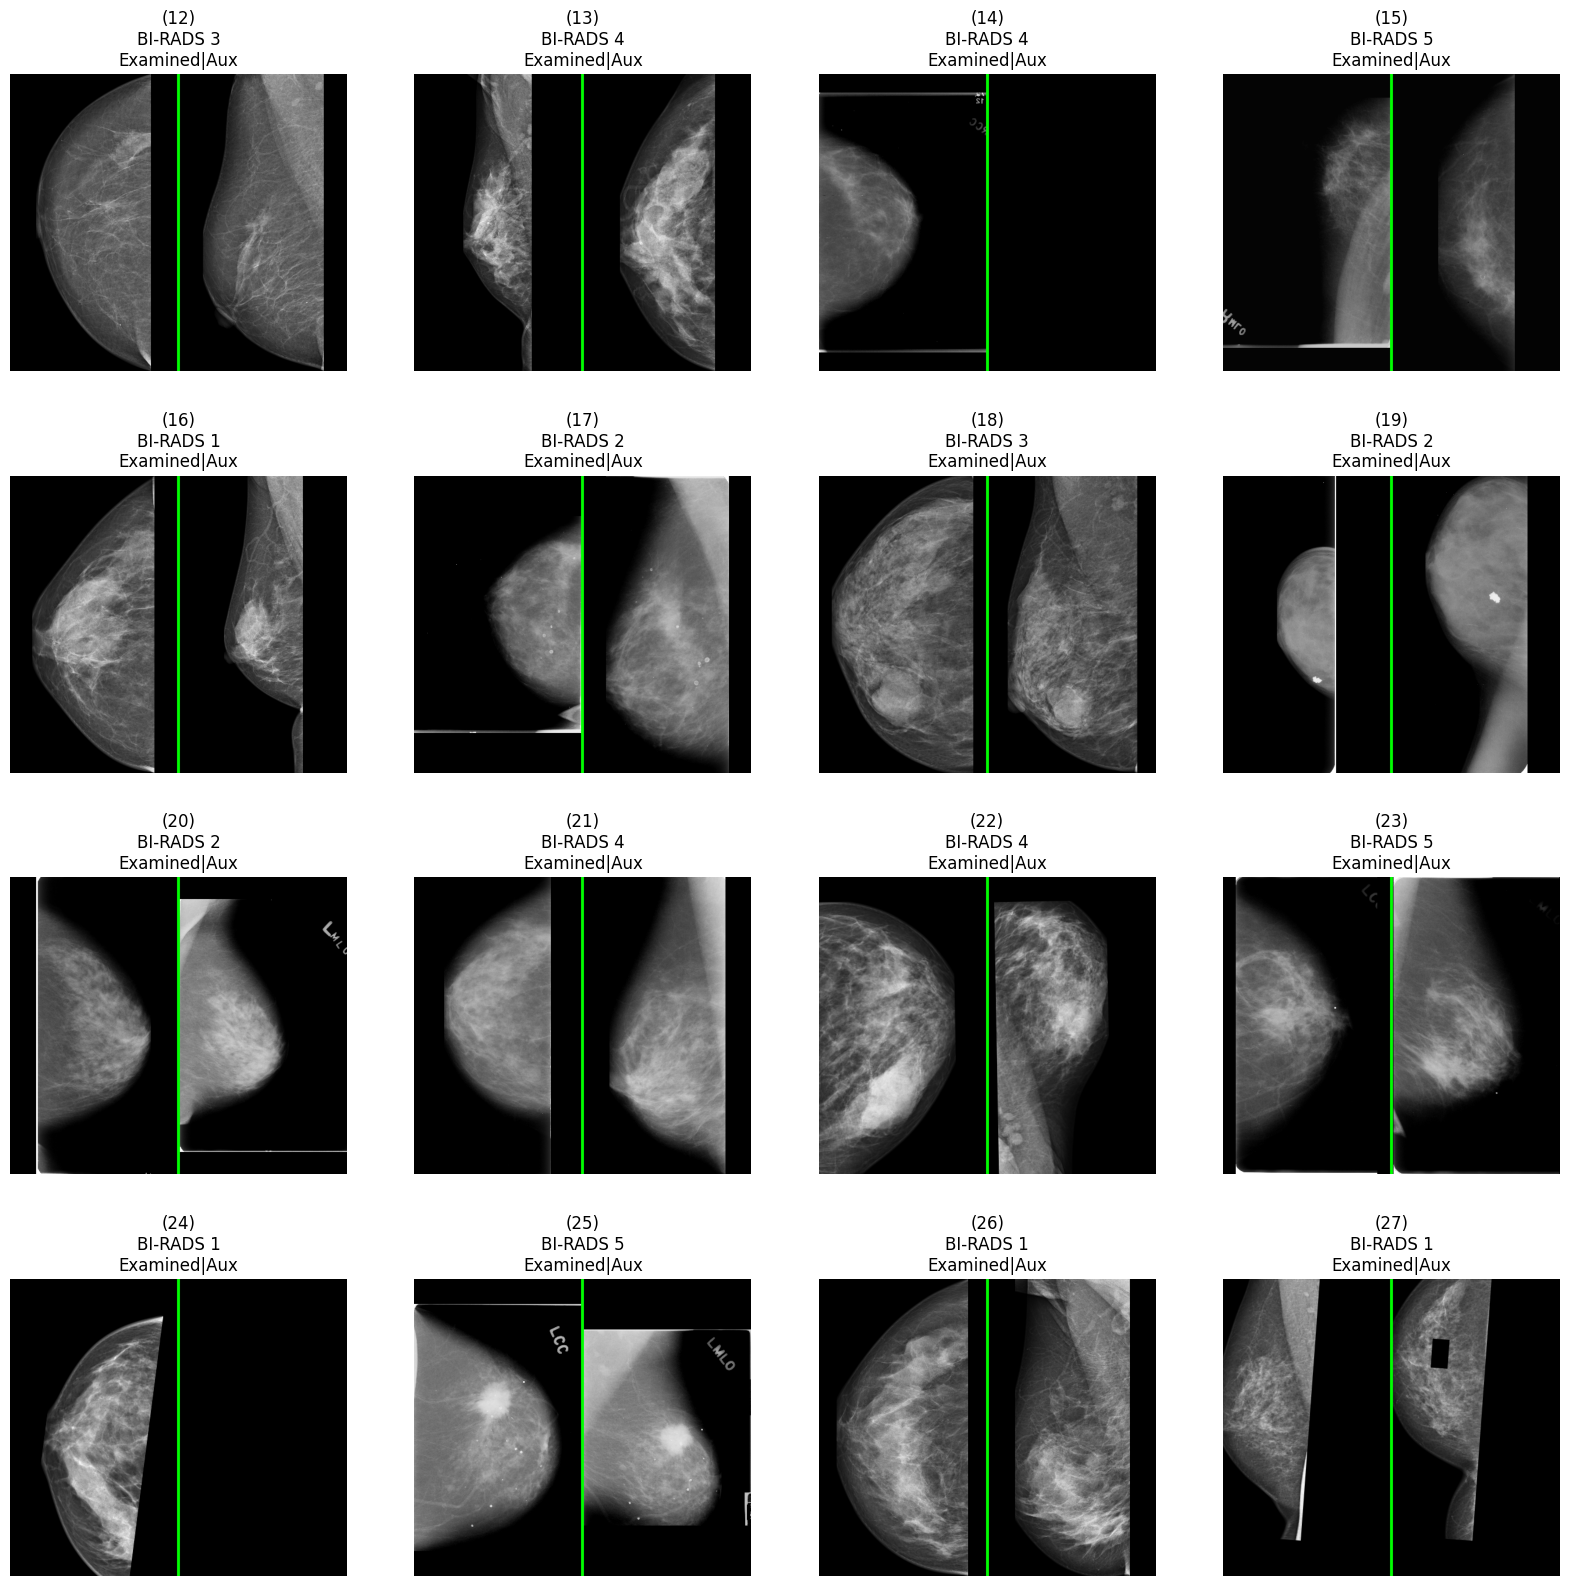

In [5]:
from tensorflow.errors import InvalidArgumentError

viz_ds = load_dataset("/kaggle/input/multi-view-dataset-v2/balanced_images_5_fold", 
                       splits={'train':[4], 'val':[4]})[0]
viz_ds = prepare_ds(viz_ds, training=True)
print(repr(viz_ds))
batch = next(iter(viz_ds))
Ex_image_batch = batch[0]['Examined']
Aux_image_batch = batch[0]['Aux']
label_batch = batch[1]
del viz_ds
ncol = 4
nrow = 4
bar_color = [0, 255, 0]
bar_thickness = 5
bar = np.array([[bar_color for i in range(bar_thickness)]
                           for j in range(D.image_size[0])])
random_start = 0 if D.batch_size < 21 else np.random.randint(0,D.batch_size-nrow*ncol)
plt.figure(figsize=(20, 5*nrow))
for i in range(nrow*ncol):
    index = random_start+i
    try:
        EX = Ex_image_batch[index].numpy().astype("uint8")
        AUX = Aux_image_batch[index].numpy().astype("uint8")
    except InvalidArgumentError:
        break
    ax = plt.subplot(nrow, ncol, i + 1)
    image = np.hstack((EX,bar,AUX))
    plt.imshow(image)
    label = label_batch[index]
    plt.title(f"({index})\nBI-RADS {np.argmax(label)+1}\nExamined|Aux")
    plt.axis("off")

# Model Training

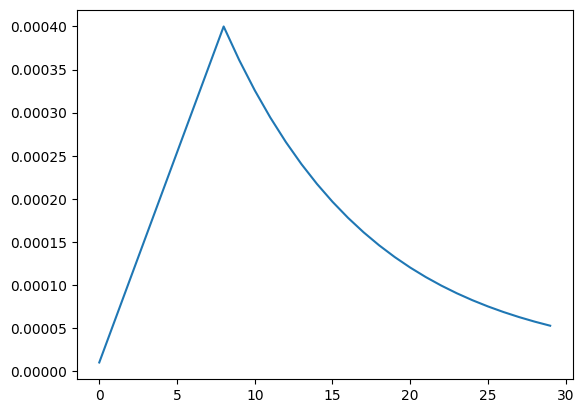

In [6]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.
def get_lr_callback(plot_schedule=False, EPOCHS=D.epochs):
    LR_START = 0.00001
    LR_MAX   = 0.00005 * strategy.num_replicas_in_sync
    LR_MIN   = 0.00001
    LR_RAMPUP_EPOCHS = round(EPOCHS*0.25)
    LR_SUSTAIN_EPOCHS = 0
    LR_EXP_DECAY = .9

    def lrfn(epoch):
        if epoch < LR_RAMPUP_EPOCHS:
            lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
        elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
            lr = LR_MAX
        else:
            lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
        return lr
    
    if plot_schedule:
        rng = [i for i in range(25 if EPOCHS < 25 else EPOCHS)]
        y = [lrfn(x) for x in rng]
        plt.plot(rng, y)

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=0)
get_lr_callback(plot_schedule=True)

In [7]:
from modul.mmv_model import (
    load_pretrained_weight,
    create_model
)

def model_compile(model):
    model.compile(
        loss=D.loss_fn,
        optimizer=D.optimizer(),
        metrics=D.metrics(),
        jit_compile=True if D.TPU else False,
    )
    return model

def model_fit(model, dataset_dir, 
              val_fold=1, initial_epoch=0,
              epoch=D.epochs, verbose = 2,
              initial_val_F1=0.4):
    k = int(dataset_dir.split("_")[-2])
    assert val_fold < k, "val_fold out of range"
    folds_train = list(range(k))
    folds_val = [folds_train.pop(val_fold)]
    train_ds, validation_ds = load_dataset(dataset_dir, splits={'train':folds_train, 'val':folds_val})
    train_ds, validation_ds = prepare_ds(train_ds, training=True), prepare_ds(validation_ds, training=False)
    ckpt_callback = keras.callbacks.ModelCheckpoint(
                        filepath=f'checkpoints/{D.model_var}_fold-{val_fold}_best.weights.h5',
                        monitor='val_macro_F1',
                        verbose=2,
                        mode='max',
                        save_best_only=True,
                        save_weights_only=True,
                        initial_value_threshold=initial_val_F1,
                       )
    history = model.fit(
        train_ds,
        initial_epoch=initial_epoch,
        epochs = epoch,
        verbose = verbose,
        validation_data=validation_ds,
        callbacks=[ckpt_callback, get_lr_callback()]
    )
    return history, ckpt_callback.best

def plot_history_metrics(history, model_name="convnext"):
    loss = history.history.pop('loss')
    val_loss = history.history.pop('val_loss')
    history.history.pop('lr')
    epochs = range(D.epochs)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.legend()
    plt.title(f'Training and validation loss | {model_name}')
    plt.figure()
    for key, values in history.history.items():
        plt.plot(epochs, values, label=key)
    plt.title(f'Training and validation metrics | {model_name}')
    plt.legend()
    plt.show()
    
def plot_history_metrics_for_multi_model(histories:dict, metric_to_plot="loss"):
    for fold, history in histories.items():
        metric_history = history.history.get(metric_to_plot)
        epochs = range(D.epochs)
        plt.plot(epochs, metric_history, label=fold)
    plt.legend()
    plt.title(f'{metric_to_plot} history')
    plt.show()
0

0

In [8]:
pretrained_weights = load_pretrained_weight(D.model_var, D.image_size)

     8192/198551472 [..............................] - ETA: 0s

  4202496/198551472 [..............................] - ETA: 3s

 14802944/198551472 [=>............................] - ETA: 1s

 26181632/198551472 [==>...........................] - ETA: 1s

 38223872/198551472 [====>.........................] - ETA: 0s

 41951232/198551472 [=====>........................] - ETA: 1s

 51920896/198551472 [======>.......................] - ETA: 0s

 64610304/198551472 [========>.....................] - ETA: 0s

 77144064/198551472 [==========>...................] - ETA: 0s

 87547904/198551472 [============>.................] - ETA: 0s

 99188736/198551472 [=============>................] - ETA: 0s

111255552/198551472 [===============>..............] - ETA: 0s

123748352/198551472 [=================>............] - ETA: 0s

135462912/198551472 [===================>..........] - ETA: 0s

147734528/198551472 [=====================>........] - ETA: 0s

160686080/198551472 [=======================>......] - ETA: 0s

173326336/198551472 [=========================>....] - ETA: 0s

185319424/198551472 [===========================>..] - ETA: 0s

198551472/198551472 [==============================] - 1s 0us/step


In [9]:
# !rm -rf keras-tuner
# hyperparams = {
#     "pooling": ['w_avg'],
#     "fusion_stage" : [1, 2, 3],
#     "fusion_block_index" : [0, 1, 2],
#     "drop_path_rate": [0.20, 0.60]
# }
# num_trials = np.prod([len(hpc) for hpc in hyperparams.values()])
# print("num_trials = ",num_trials)
# def build_model(hp):
#     hp_kwargs = { key:hp.Choice(key, value, ordered=False) for key, value in hyperparams.items()}
#     with strategy.scope():
#         model = create_model(
#                              pretrained_weights=pretrained_weights,
#                              **hp_kwargs
#                             )
#     return model
# tuner = keras_tuner.GridSearch(
#     hypermodel=build_model,
#     objective=keras_tuner.Objective('val_macro_F1', 'max'),
#     max_trials=num_trials,
#     seed=911,
#     overwrite=False,
#     directory="/kaggle/working",
#     project_name='keras-tuner',
# )
# tuner.search_space_summary()

In [10]:
histories = {}
models_best_f1_score = []
k = 5
dataset_balancing = "balanced"
dataset_dir = f"/kaggle/input/multi-view-dataset-v2/{dataset_balancing}_images_{k}_fold"
with strategy.scope():
    for fold in range(k):
        model = create_model(model_var=D.model_var, 
                             fusion_stage=D.fusion_stage,
                             fusion_block_index=D.fusion_index,
                             fc_layers_depth=D.fc_layers_depth, 
                             fc_layers_dims=D.fc_layers_dims, 
                             drop_path_rate=D.drop_path_rate,
                             drop_out_rate=D.dropout_rate,
                             pooling=D.pooling,
                             pretrained_weights=pretrained_weights,
                            )
        model = model_compile(model)
        print(f"training model fold-{fold}".center(40,"-"),"\nprevious fold result :", models_best_f1_score)
        history, best_f1_score = model_fit(model, dataset_dir, fold,
                                            verbose = 2 if D.TPU else 1, 
                                            initial_val_F1=0.0
                                           )
        histories[f"fold-{fold}"] = history
        models_best_f1_score.append(best_f1_score)
        model.load_weights(f"checkpoints/{D.model_var}_fold-{fold}_best.weights.h5")
        model.save(f"{D.model_var}_fold-{fold}_best-{best_f1_score:.3f}.h5", include_optimizer=False)
        del model
        clear_output()
print(f"training finished".center(40,"-"))
!rm -rf checkpoints
print("F1-Score result :")
print("\n".join([f"fold-{i} = {score}" for i, score in enumerate(models_best_f1_score)]))

-----------training finished------------


F1-Score result :
fold-0 = 0.5805377960205078
fold-1 = 0.5453399419784546
fold-2 = 0.6222624182701111
fold-3 = 0.6121886372566223
fold-4 = 0.5782647132873535


# Result

In [11]:
# tuner.results_summary(num_trials)

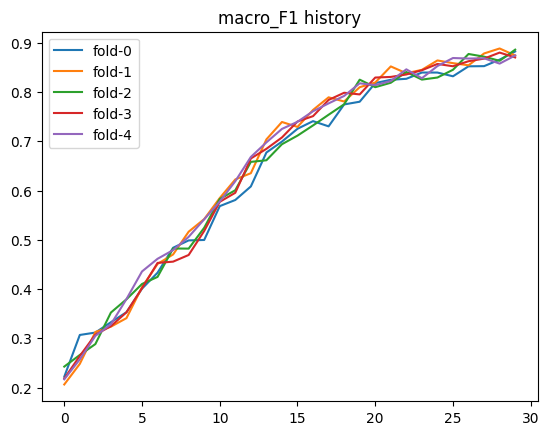

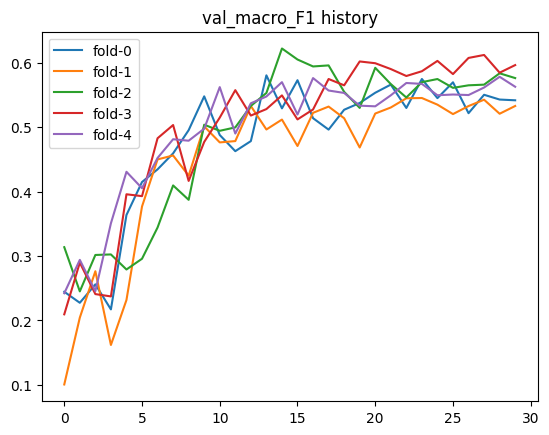

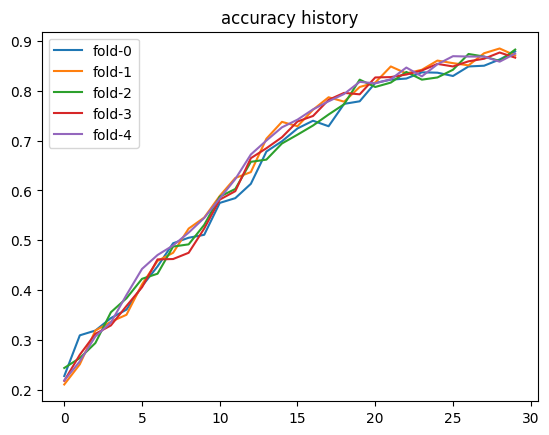

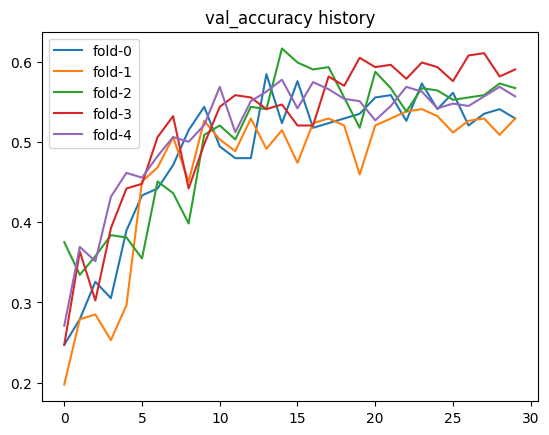

In [12]:
plot_history_metrics_for_multi_model(histories, metric_to_plot="macro_F1")
plot_history_metrics_for_multi_model(histories, metric_to_plot="val_macro_F1")
plot_history_metrics_for_multi_model(histories, metric_to_plot="accuracy")
plot_history_metrics_for_multi_model(histories, metric_to_plot="val_accuracy")

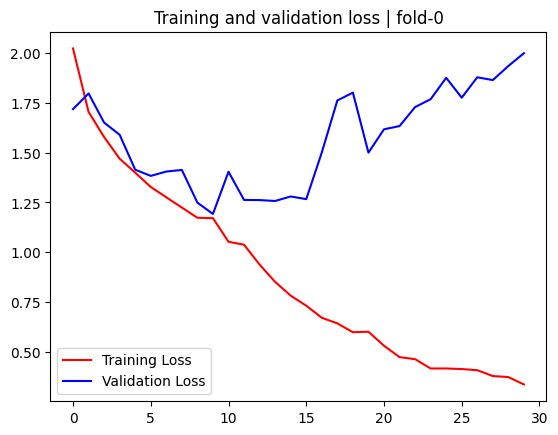

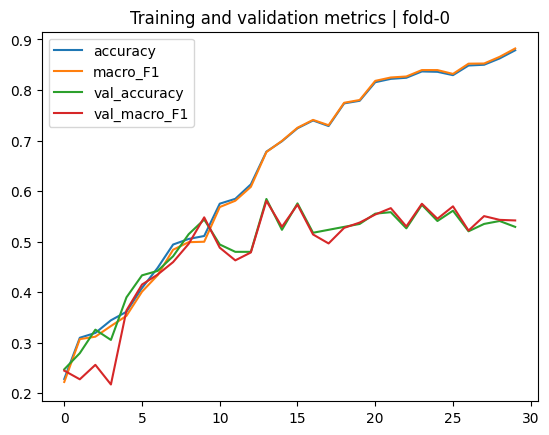

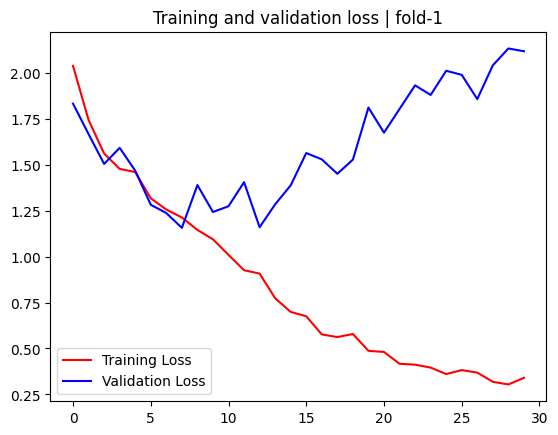

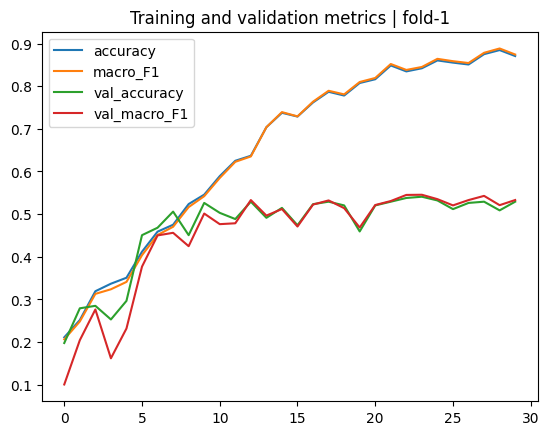

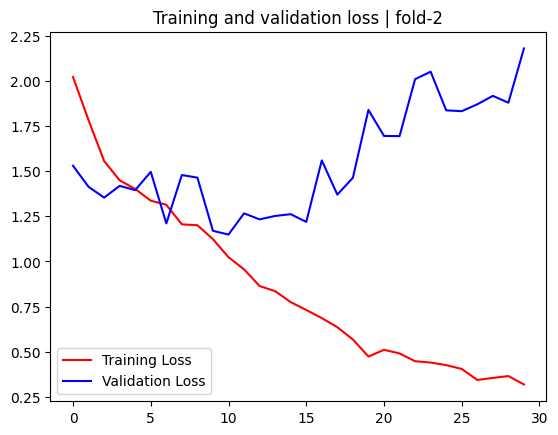

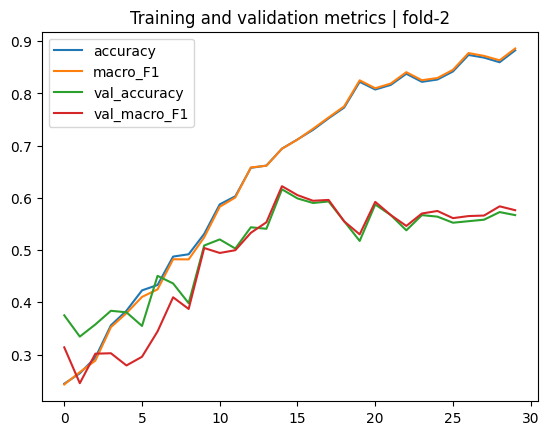

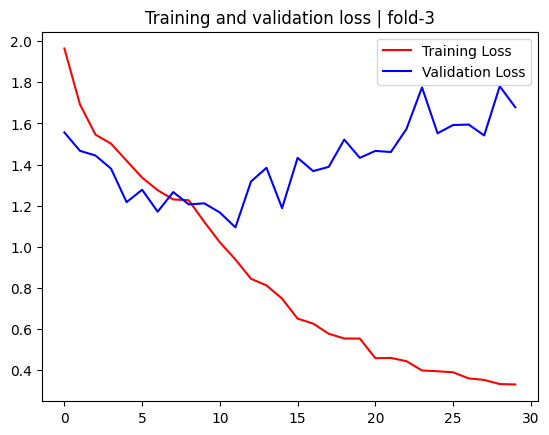

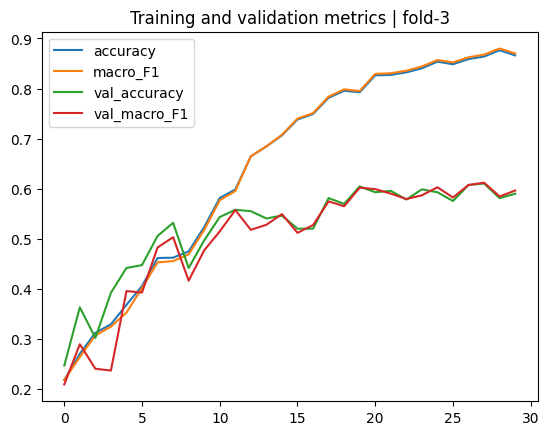

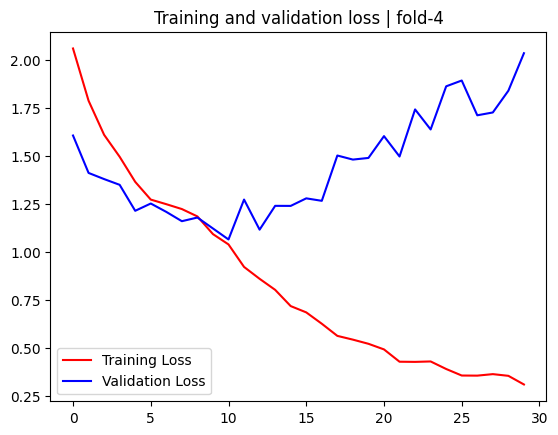

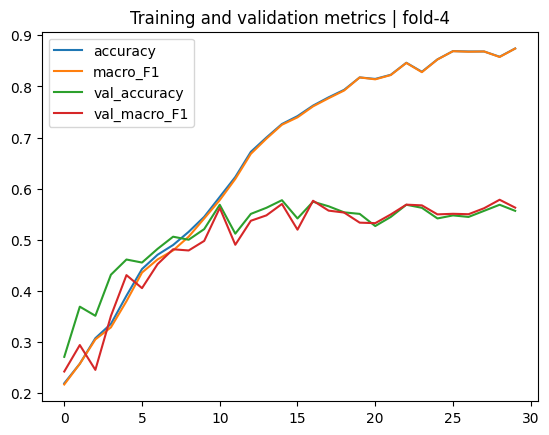

In [13]:
for fold, history in histories.items():
    plot_history_metrics(history, model_name=fold)

In [14]:
!rm -rf modul